In [ ]:
pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 44.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:
# Preprocess the SMILES strings to generate molecular fingerprints
def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(fp)
    else:
        return None

In [ ]:
# Load your dataset
# Replace 'your_dataset.csv' with the actual name of your dataset file
#data = pd.read_csv('/content/molecule_properties.csv')
data = pd.read_csv('book3.csv')
#print(data)
# Apply the preprocessing to the entire dataset
X = np.array([smiles_to_fp(smiles) for smiles in data['SMILES']])
print(X.shape)
Y = data['Toxicity'].apply(lambda x: 1 if x == 'Toxic' else 0).values
print(Y.shape)


FileNotFoundError: ignored

In [ ]:
# Convert to PyTorch tensors
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = torch.FloatTensor(X_train)
Y_train = torch.FloatTensor(Y_train).view(-1, 1)  # Reshape to (batch_size, 1)
X_val = torch.FloatTensor(X_val)
Y_val = torch.FloatTensor(Y_val).view(-1, 1)  # Reshape to (batch_size, 1)
print(X_train.shape)


In [ ]:
# Model definition
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(GCN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X):
        X = self.fc1(X)
        X = self.relu(X)
        X = self.dropout(X)
        X = self.fc2(X)
        return torch.sigmoid(X)

In [ ]:
print(X_train.shape[1])

In [ ]:
# Initialize the model
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1
model = GCN(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
batch_size = 32

for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        Y_batch = Y_train[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Validation
with torch.no_grad():
    model.eval()
    val_outputs = model(X_val)
    val_loss = criterion(val_outputs, Y_val)
    print(f'Validation Loss: {val_loss.item():.4f}')


In [ ]:
# Assuming you have already trained the GCN model and loaded it into the 'model' variable

# 1. Preprocess the SMILES string of the new molecule
new_smiles =" CC(=O)NC1=CC=C(C=C1)O"
new_fp = smiles_to_fp(new_smiles)

# Check if the SMILES string is valid
if new_fp is not None:
    # 2. Convert the fingerprint to a PyTorch tensor
    new_fp_tensor = torch.FloatTensor(new_fp)

    # 3. Make predictions using the trained model
    with torch.no_grad():
        model.eval()
        prediction = model(new_fp_tensor.unsqueeze(0))  # Unsqueeze to add a batch dimension
        probability_toxic = prediction.item()

    print(f"The predicted probability of toxicity for the new molecule is: {probability_toxic:.4f}")
else:
    print("Invalid SMILES string. Please provide a valid SMILES for the new molecule.")


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Load your dataset
# Replace 'your_dataset.csv' with the actual name of your dataset file
data = pd.read_csv('/content/Book2 (Autosaved).csv')

# Preprocess the SMILES strings to generate molecular fingerprints
def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(fp)
    else:
        return None

# Apply the preprocessing to the entire dataset
X = np.array([smiles_to_fp(smiles) for smiles in data['SMILES']])
Y = data['Toxicity'].apply(lambda x: 1 if x == 'Toxic' else 0).values

# Convert to PyTorch tensors
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = torch.FloatTensor(X_train)
Y_train = torch.FloatTensor(Y_train).view(-1, 1)  # Reshape to (batch_size, 1)
X_val = torch.FloatTensor(X_val)
Y_val = torch.FloatTensor(Y_val).view(-1, 1)  # Reshape to (batch_size, 1)

# Define the GCN model with increased capacity
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        super(GCN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X):
        X = self.fc1(X)
        X = self.relu(X)
        X = self.dropout(X)
        X = self.fc2(X)
        X = self.relu(X)
        X = self.dropout(X)
        X = self.fc3(X)
        return torch.sigmoid(X)

# Initialize the model with increased capacity
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
output_size = 1
model = GCN(input_size, hidden_size1, hidden_size2, output_size)

# Loss and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_loss_list = []
f1_list = []
confusion_list = []
accuracy_list = []

# Training loop with learning rate scheduling
epochs = 400
batch_size = 2

for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        Y_batch = Y_train[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lr_scheduler.step()

    # Validation
    with torch.no_grad():
        model.eval()
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    # Metrics for training set
    model.eval()
    train_outputs = model(X_train)
    train_loss = criterion(train_outputs, Y_train)

    # F1 score, confusion matrix, accuracy
    train_preds = (train_outputs >= 0.5).float()
    f1 = f1_score(Y_train, train_preds)
    confusion = confusion_matrix(Y_train, train_preds)
    accuracy = accuracy_score(Y_train, train_preds)

    train_loss_list.append(train_loss.item())
    f1_list.append(f1)
    confusion_list.append(confusion)
    accuracy_list.append(accuracy)

    print(f'Training Loss: {train_loss.item():.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}')

# Plotting loss over epochs
plt.plot(range(1, epochs+1), train_loss_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting F1 score over epochs
plt.plot(range(1, epochs+1), f1_list, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Print confusion matrix and accuracy for the last epoch
print(f'Confusion Matrix (Last Epoch):\n{confusion_list[-1]}')
print(f'Accuracy (Last Epoch): {accuracy_list[-1]:.4f}')

# Assuming you have a test set and labels (X_test, Y_test) defined before this point
# Evaluate the model on the test set
# Assuming you have a CSV file for your test set named 'test_dataset.csv'



In [ ]:
test_data = pd.read_csv('/content/book3.csv')

# Preprocess the SMILES strings to generate molecular fingerprints for the test set
X_test = np.array([smiles_to_fp(smiles) for smiles in test_data['SMILES']])
Y_test = test_data['Toxicity'].apply(lambda x: 1 if x == 'Toxic' else 0).values

# Convert to PyTorch tensors
X_test = torch.FloatTensor(X_test)
Y_test = torch.FloatTensor(Y_test).view(-1, 1)  # Reshape to (batch_size, 1)

with torch.no_grad():
    model.eval()
    test_outputs = model(X_test)
    test_predictions = (test_outputs >= 0.5).float()  # Convert to binary predictions (0 or 1)
    # Assuming Y_test is the ground truth labels
    test_accuracy = accuracy_score(Y_test, test_predictions)

    print(f'Test Accuracy: {test_accuracy:.4f}')


In [ ]:
# Assuming you have already trained the GCN model and loaded it into the 'model' variable

# 1. Preprocess the SMILES string of the new molecule
new_smiles ="CCO"
new_fp = smiles_to_fp(new_smiles)

# Check if the SMILES string is valid
if new_fp is not None:
    # 2. Convert the fingerprint to a PyTorch tensor
    new_fp_tensor = torch.FloatTensor(new_fp)

    # 3. Make predictions using the trained model
    with torch.no_grad():
        model.eval()
        prediction = model(new_fp_tensor.unsqueeze(0))  # Unsqueeze to add a batch dimension
        probability_toxic = prediction.item()

    print(f"The predicted probability of toxicity for the new molecule is: {probability_toxic:.4f}")
else:
    print("Invalid SMILES string. Please provide a valid SMILES for the new molecule.")


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

def morgan_fingerprint(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Generate Morgan fingerprint as a bit vector
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

    # Convert the bit vector to an integer
    fingerprint = int(fp.ToBitString(), 2)

    return fingerprint

# Example usage:
smiles_example = "CCO"  # Ethanol
morgan_fp = morgan_fingerprint(smiles_example)

if morgan_fp is not None:
    print(f"Morgan Fingerprint: {morgan_fp}")
else:
    print("Invalid SMILES input.")


GCN using varied data

In [ ]:
pip install deepchem


In [ ]:
pip install torch_geometric

In [ ]:
pip install rdkit

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/300, Loss: 1.3938272037813741, F1 Score: 0.7699406723796968
Epoch 2/300, Loss: 0.5769965052604675, F1 Score: 0.7474747474747475
Epoch 3/300, Loss: 0.5240621009180623, F1 Score: 0.7802768166089966
Epoch 4/300, Loss: 0.5186480495237535, F1 Score: 0.7793991416309013
Epoch 5/300, Loss: 0.5273962655375081, F1 Score: 0.8017467248908298
Epoch 6/300, Loss: 0.4864801774101873, F1 Score: 0.8036454018227008
Epoch 7/300, Loss: 0.47406093535884736, F1 Score: 0.8280757097791798
Epoch 8/300, Loss: 0.4657880731167332, F1 Score: 0.8092691622103386
Epoch 9/300, Loss: 0.47130292750174, F1 Score: 0.8281786941580757
Epoch 10/300, Loss: 0.45577263063000095, F1 Score: 0.8132854578096947
Epoch 11/300, Loss: 0.475666469143283, F1 Score: 0.8192968111201961
Epoch 12/300, Loss: 0.4464914491099696, F1 Score: 0.8345802161263508
Epoch 13/300, Loss: 0.4303894552492326, F1 Score: 0.8359872611464968
Epoch 14/300, Loss: 0.4418780707543896, F1 Score: 0.8259325044404973
Epoch 15/300, Loss: 0.42223808265501456, F1 

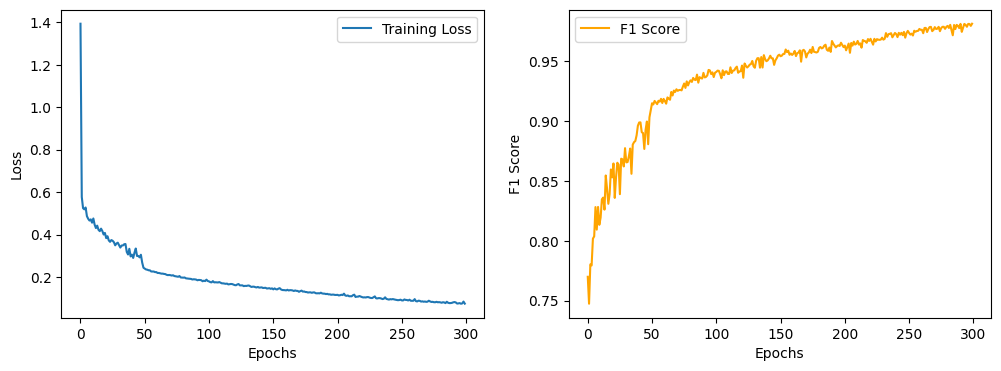

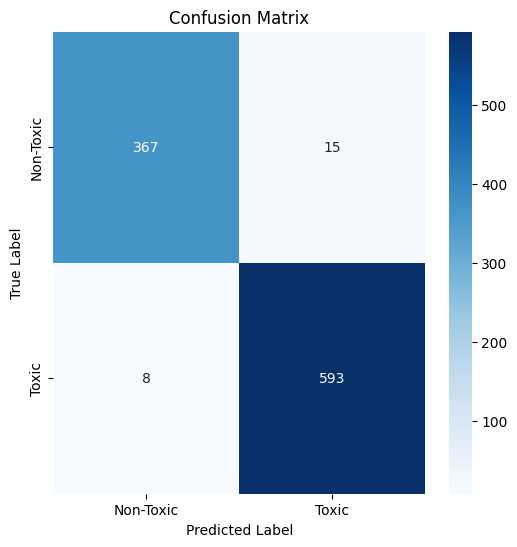

Accuracy: 0.9766022380467956


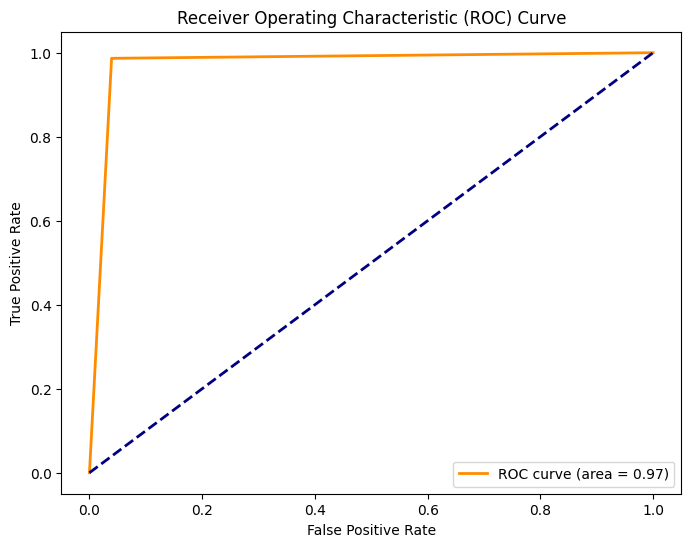

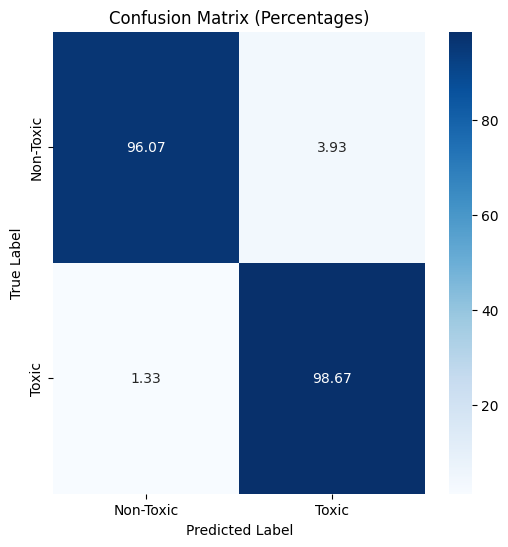

In [ ]:
import deepchem as dc
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GraphConv, global_add_pool
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

# Load the data
data = pd.read_csv('/content/train.csv')  # Replace 'your_data.csv' with the actual file path

# Preprocess the data
smiles_list = data['SMILES'].tolist()
toxicity_labels = (data['Toxicity'] == 'Toxic').astype(int).tolist()
print(toxicity_labels)

# Generate molecular graphs
featurizer = dc.feat.ConvMolFeaturizer()
graphs = featurizer(smiles_list)

# Create a PyTorch Geometric dataset
class MolGraphDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        mol = self.graphs[idx]
        label = self.labels[idx]

        x = torch.tensor(mol.get_atom_features(), dtype=torch.float)
        edge_list = mol.get_adjacency_list()
        edge_index = torch.tensor([(i, j) for i, edges in enumerate(edge_list) for j in edges], dtype=torch.long).t()
        y = torch.tensor([label], dtype=torch.float)  # Keep the target tensor as a 1D tensor

        return Data(x=x, edge_index=edge_index, y=y)

# Create the dataset and dataloader
dataset = MolGraphDataset(graphs, toxicity_labels)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.graph_conv1 = GraphConv(input_dim, hidden_dim)
        self.graph_conv2 = GraphConv(hidden_dim, hidden_dim)
        self.dense = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.graph_conv1(x, edge_index)
        x = torch.relu(x)
        x = self.graph_conv2(x, edge_index)
        x = torch.relu(x)
        x = global_add_pool(x, batch)
        output = self.dense(x)
        return output

# Instantiate the model, loss function, and optimizer
model = GCN(input_dim=graphs[0].get_atom_features().shape[1],
            hidden_dim=64,
            output_dim=1)  # Binary classification for toxicity

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adjusted learning rate

# Add gradient clipping
clip_value = 1.0  # Experiment with different values
torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

# Add learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

num_epochs = 300
train_losses = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch in loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output.squeeze(), batch.y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(loader)
    train_losses.append(avg_epoch_loss)

    # Evaluation on the entire dataset for accuracy and F1 score
    model.eval()
    all_predictions = []
    all_labels = []

    for batch in loader:
        output = model(batch)
        predictions = torch.sigmoid(output).round().squeeze().detach().cpu().numpy()
        labels = batch.y.squeeze().cpu().numpy()

        all_predictions.extend(predictions)
        all_labels.extend(labels)

    # Calculate F1 score
    f1 = f1_score(all_labels, np.round(all_predictions))
    f1_scores.append(f1)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss}, F1 Score: {f1}')

    # Update learning rate using scheduler
    scheduler.step(avg_epoch_loss)

# Plotting the loss curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting F1 score vs epochs
plt.subplot(1, 2, 2)
plt.plot(f1_scores, label='F1 Score', color='orange')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, np.round(all_predictions))
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print accuracy
accuracy = (np.array(all_labels) == np.round(all_predictions)).mean()
print(f'Accuracy: {accuracy}')

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting the confusion matrix with percentages
conf_matrix_percentages = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_percentages, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages)')
plt.show()


In [ ]:
# Load the test data
test_data = pd.read_csv('/content/test_1.csv')  # Replace 'test_data.csv' with the actual file path

# Preprocess the test data
test_smiles_list = test_data['SMILES'].tolist()
test_toxicity_labels = (test_data['Toxicity'] == 'Toxic').astype(int).tolist()

# Generate molecular graphs for the test data
test_graphs = featurizer(test_smiles_list)
test_dataset = MolGraphDataset(test_graphs, test_toxicity_labels)
test_loader = DataLoader(test_dataset, batch_size=42, shuffle=False)

# Evaluation on the test dataset
model.eval()
total_correct_test = 0
total_samples_test = 0
test_losses = []

for test_batch in test_loader:
    output_test = model(test_batch)
    predictions_test = torch.sigmoid(output_test).round().squeeze().detach().cpu().numpy()
    labels_test = test_batch.y.squeeze().cpu().numpy()

    total_correct_test += np.sum(predictions_test == labels_test)
    total_samples_test += len(labels_test)

    test_loss = criterion(output_test.squeeze(), test_batch.y)
    test_losses.append(test_loss.item())

# Calculate test accuracy
test_accuracy = total_correct_test / total_samples_test
print(f'Accuracy on the test dataset: {test_accuracy * 100:.2f}%')

# Calculate average test loss
#avg_test_loss = np.mean(test_losses)
#print(f'Average Test Loss: {avg_test_loss}')



Accuracy on the test dataset: 83.33%


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Example of making predictions for a new SMILES string
new_smiles = 'C[Se]CC[C@H](N)C(=O)O'
new_graph = featurizer([new_smiles])[0]

# Create a Data object for the new element
new_data = Data(
    x=torch.tensor(new_graph.get_atom_features(), dtype=torch.float),
    edge_index=torch.tensor(
        [(i, j) for i, edges in enumerate(new_graph.get_adjacency_list()) for j in edges],
        dtype=torch.long
    ).t(),
)




# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    # Pass the new_data through the model
    output = model(new_data)

# Convert the output to a probability using sigmoid
predicted_toxicity = torch.sigmoid(output).item()

print(f'Predicted Toxicity for {new_smiles}: {predicted_toxicity:.2f}')




In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Create a molecule with a single carbon atom
mol = Chem.MolFromSmiles('C')

# Calculate RDKit descriptors
rdkit_descriptors = [(desc[0], desc[1](mol)) for desc in Descriptors.descList]

# Print the descriptor names and values
print("Feature List for Carbon (C) Atom:")
for descriptor_name, value in rdkit_descriptors:
    print(f"{descriptor_name}: {value}")


Feature List for Carbon (C) Atom:
MaxAbsEStateIndex: 0.0
MaxEStateIndex: 0.0
MinAbsEStateIndex: 0.0
MinEStateIndex: 0.0
qed: 0.3597849378839701
SPS: 0.0
MolWt: 16.043
HeavyAtomMolWt: 12.011
ExactMolWt: 16.031300127999998
NumValenceElectrons: 8
NumRadicalElectrons: 0
MaxPartialCharge: -0.07755789119307553
MinPartialCharge: -0.07755789119307553
MaxAbsPartialCharge: 0.07755789119307553
MinAbsPartialCharge: 0.07755789119307553
FpDensityMorgan1: 1.0
FpDensityMorgan2: 1.0
FpDensityMorgan3: 1.0
BCUT2D_MWHI: 12.011
BCUT2D_MWLOW: 12.011
BCUT2D_CHGHI: -0.07755789119307553
BCUT2D_CHGLO: -0.07755789119307553
BCUT2D_LOGPHI: 0.1441
BCUT2D_LOGPLOW: 0.1441
BCUT2D_MRHI: 2.503
BCUT2D_MRLOW: 2.503
AvgIpc: 0.0
BalabanJ: 0.0
BertzCT: 0
Chi0: 0
Chi0n: 0.0
Chi0v: 0.0
Chi1: 0
Chi1n: 0.0
Chi1v: 0.0
Chi2n: 0.0
Chi2v: 0.0
Chi3n: 0.0
Chi3v: 0.0
Chi4n: 0.0
Chi4v: 0.0
HallKierAlpha: 0.0
Ipc: 0.0
Kappa1: 0.0
Kappa2: 0.0
Kappa3: 0.0
LabuteASA: 8.739251027829551
PEOE_VSA1: 0.0
PEOE_VSA10: 0.0
PEOE_VSA11: 0.0
PEOE_VSA1

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Data(x=[4, 20], edge_index=[2, 6])
Edge Index:
tensor([[0, 1, 0, 2, 0, 3],
        [1, 0, 2, 0, 3, 0]])

Atom Features:
tensor([[ 6.0000,  3.0000,  0.0000,  0.0000,  0.0000, 12.0110,  0.0000,  0.0000,
          1.0000,  0.0000,  3.0000,  4.0000,  3.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  1.0000,  0.0000,  3.0000],
        [17.0000,  1.0000,  0.0000,  0.0000,  0.0000, 35.4530,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  4.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000],
        [17.0000,  1.0000,  0.0000,  0.0000,  0.0000, 35.4530,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  4.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000],
        [17.0000,  1.0000,  0.0000,  0.0000,  0.0000, 35.4530,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  4.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000]])
Epoch 1/300, Loss: 10.646812954256612, F1 Score

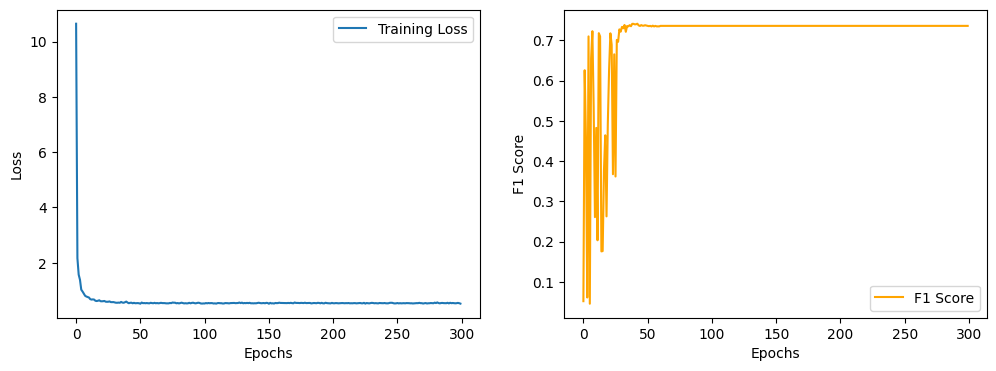

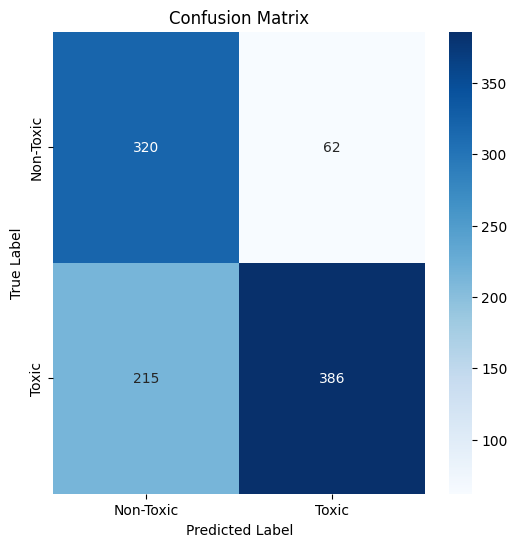

Accuracy: 0.7182095625635809


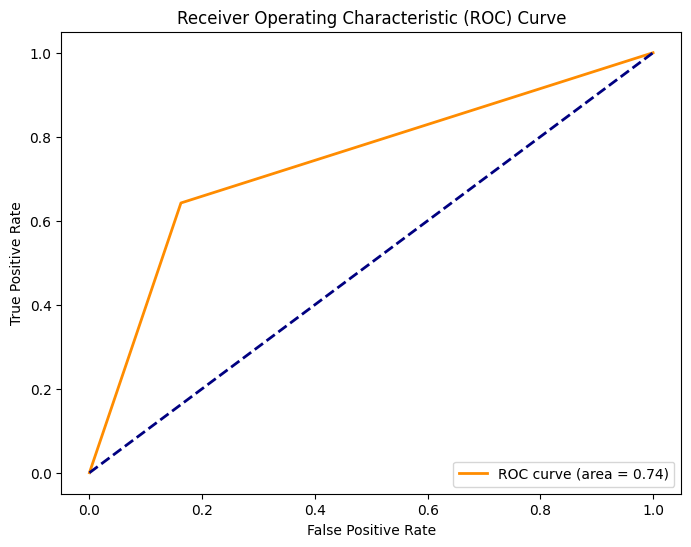

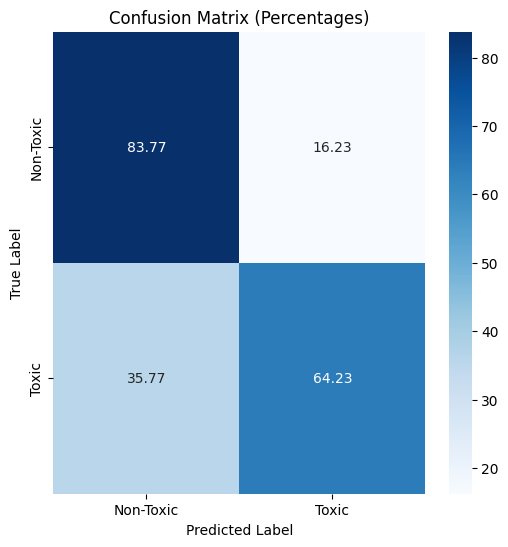

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GraphConv, global_add_pool
from rdkit import Chem
import pandas as pd
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/content/train.csv')  # Replace 'your_data.csv' with the actual file path

# Preprocess the data
smiles_list = data['SMILES'].tolist()
toxicity_labels = (data['Toxicity'] == 'Toxic').astype(int).tolist()

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

def mol_to_graph(mol):
    num_atoms = mol.GetNumAtoms()

    # Extract atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.extend([atom.GetAtomicNum(),
                              atom.GetDegree(),
                              atom.GetFormalCharge(),
                              atom.GetImplicitValence(),
                              atom.GetIsAromatic(),
                              atom.GetMass(),
                              atom.GetNumExplicitHs(),
                              atom.GetNumImplicitHs(),
                              atom.GetNumRadicalElectrons(),
                              atom.GetTotalNumHs(),
                              atom.GetTotalValence(),
                              atom.GetHybridization(),
                              atom.GetExplicitValence(),
                              atom.GetIsotope(),
                              atom.GetChiralTag(),
                              atom.GetNumImplicitHs(),
                              atom.GetNumRadicalElectrons(),
                              atom.GetNumRadicalElectrons(),
                              atom.GetTotalNumHs(),
                              atom.GetTotalValence()])

    x = np.array(atom_features).reshape(-1, len(atom_features) // num_atoms)

    # Generate edge indices dynamically based on the molecule's connectivity
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # Assuming an undirected graph

    edge_index = torch.tensor(edge_index, dtype=torch.long).t()

    # Create a Data object
    data = Data(x=torch.tensor(x, dtype=torch.float), edge_index=edge_index)

    return data





# Create a list of graphs, each with its own batch attribute
graphs = [mol_to_graph(mol) for mol in mols]



from torch.utils.data import Dataset

class MolGraphDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph = self.graphs[idx]
        label = self.labels[idx]
        return graph, label

# Create the dataset and dataloader
dataset = MolGraphDataset(graphs, toxicity_labels)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Print the first element
first_element = graphs[5]
print(first_element)

# Print edge index
print("Edge Index:")
print(first_element.edge_index)

# Print atom features
print("\nAtom Features:")
print(first_element.x)


class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(GCN, self).__init__()
        self.graph_conv1 = GraphConv(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.graph_conv2 = GraphConv(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.graph_conv3 = GraphConv(hidden_dim, hidden_dim)  # New layer
        self.dropout3 = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.graph_conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.graph_conv2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.graph_conv3(x, edge_index)  # New layer
        x = torch.relu(x)
        x = self.dropout3(x)
        x = global_add_pool(x, batch)
        output = self.dense(x)
        return output


# Instantiate the model with dropout and an additional layer
model = GCN(input_dim=graphs[0].x.shape[1], hidden_dim=128, output_dim=1, dropout_rate=0.5)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Reduced learning rate

# Add gradient clipping
clip_value = 1  # Adjusted gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

# Add learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

# Rest of your code remains unchanged

# Training loop
num_epochs = 300

train_losses = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_data in loader:
        optimizer.zero_grad()

        # Unpack the batch
        input_features, labels = batch_data[0], batch_data[1]

        # Forward pass
        output = model(input_features)

        # Calculate loss
        loss = criterion(output.squeeze(), labels.float())  # Adjust based on your data types

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(loader)
    train_losses.append(avg_epoch_loss)

    # Evaluation on the entire dataset for accuracy and F1 score
    model.eval()
    all_predictions = []
    all_labels = []

    for batch_data in loader:
        # Unpack the batch
        input_features, labels = batch_data[0], batch_data[1]

        # Forward pass
        output = model(input_features)

        predictions = torch.sigmoid(output).round().squeeze().detach().cpu().numpy()
        labels = labels.squeeze().cpu().numpy()

        all_predictions.extend(predictions)
        all_labels.extend(labels)

    # Calculate F1 score
    f1 = f1_score(all_labels, np.round(all_predictions))
    f1_scores.append(f1)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss}, F1 Score: {f1}')

# Rest of your code remains unchanged


    # Update learning rate using scheduler
    scheduler.step(avg_epoch_loss)

# The rest of your code remains unchanged


# Plotting the loss curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting F1 score vs epochs
plt.subplot(1, 2, 2)
plt.plot(f1_scores, label='F1 Score', color='orange')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, np.round(all_predictions))
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print accuracy
accuracy = (np.array(all_labels) == np.round(all_predictions)).mean()
print(f'Accuracy: {accuracy}')

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting the confusion matrix with percentages
conf_matrix_percentages = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_percentages, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages)')
plt.show()

In [ ]:
# Evaluate the model on the test set
model.eval()
test_predictions = []
test_labels = []

with torch.no_grad():
    for batch_data in test_loader:
        # Unpack the batch
        input_features, labels = batch_data[0], batch_data[1]

        output = model(input_features)
        predictions = torch.sigmoid(output).round().squeeze().cpu().numpy()
        labels = labels.squeeze().cpu().numpy()

        test_predictions.extend(predictions)
        test_labels.extend(labels)

# Calculate accuracy for the test set
test_accuracy = (np.array(test_labels) == np.round(test_predictions)).mean()
print(f'Test Accuracy: {test_accuracy}')


Test Accuracy: 0.6666666666666666


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Data(x=[4, 20], edge_index=[2, 6])
Edge Index:
tensor([[0, 1, 0, 2, 0, 3],
        [1, 0, 2, 0, 3, 0]])

Atom Features:
tensor([[ 6.0000,  3.0000,  0.0000,  0.0000,  0.0000, 12.0110,  0.0000,  0.0000,
          1.0000,  0.0000,  3.0000,  4.0000,  3.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  1.0000,  0.0000,  3.0000],
        [17.0000,  1.0000,  0.0000,  0.0000,  0.0000, 35.4530,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  4.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000],
        [17.0000,  1.0000,  0.0000,  0.0000,  0.0000, 35.4530,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  4.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000],
        [17.0000,  1.0000,  0.0000,  0.0000,  0.0000, 35.4530,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  4.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000]])
Epoch 1/300, Loss: 33.752712893870566, F1 Score

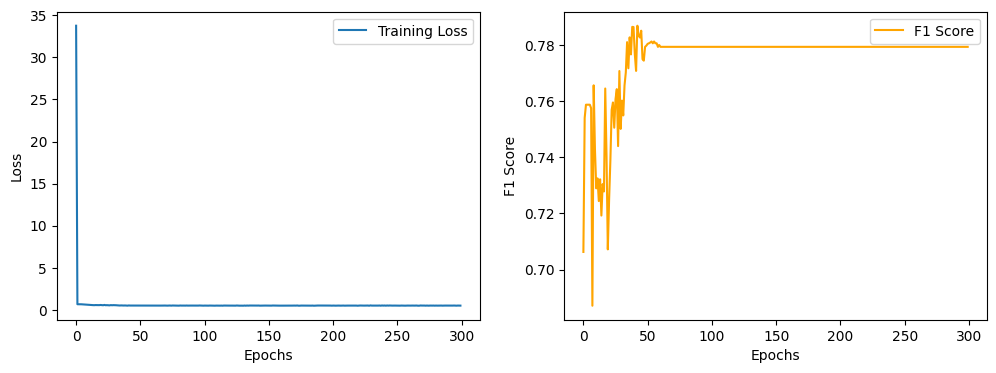

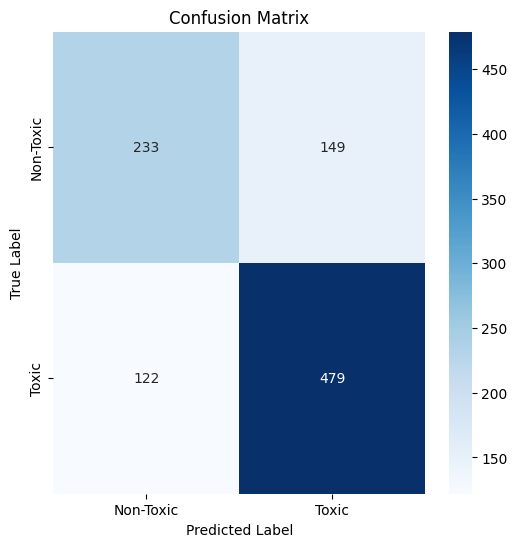

Accuracy: 0.7243133265513734


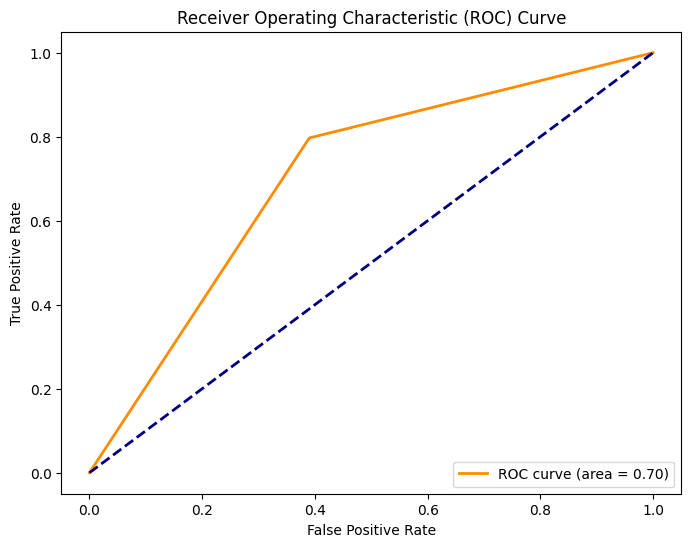

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GraphConv, global_add_pool
from rdkit import Chem
import pandas as pd
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Load the data
data = pd.read_csv('/content/train.csv')  # Replace 'your_data.csv' with the actual file path

# Preprocess the data
smiles_list = data['SMILES'].tolist()
toxicity_labels = (data['Toxicity'] == 'Toxic').astype(int).tolist()

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

def mol_to_graph(mol):
    num_atoms = mol.GetNumAtoms()

    # Extract atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.extend([atom.GetAtomicNum(),
                              atom.GetDegree(),
                              atom.GetFormalCharge(),
                              atom.GetImplicitValence(),
                              atom.GetIsAromatic(),
                              atom.GetMass(),
                              atom.GetNumExplicitHs(),
                              atom.GetNumImplicitHs(),
                              atom.GetNumRadicalElectrons(),
                              atom.GetTotalNumHs(),
                              atom.GetTotalValence(),
                              atom.GetHybridization(),
                              atom.GetExplicitValence(),
                              atom.GetIsotope(),
                              atom.GetChiralTag(),
                              atom.GetNumImplicitHs(),
                              atom.GetNumRadicalElectrons(),
                              atom.GetNumRadicalElectrons(),
                              atom.GetTotalNumHs(),
                              atom.GetTotalValence()])

    x = np.array(atom_features).reshape(-1, len(atom_features) // num_atoms)

    # Generate edge indices dynamically based on the molecule's connectivity
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # Assuming an undirected graph

    edge_index = torch.tensor(edge_index, dtype=torch.long).t()

    # Create a Data object
    data = Data(x=torch.tensor(x, dtype=torch.float), edge_index=edge_index)

    return data





# Create a list of graphs, each with its own batch attribute
graphs = [mol_to_graph(mol) for mol in mols]



from torch.utils.data import Dataset

class MolGraphDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph = self.graphs[idx]
        label = self.labels[idx]
        return graph, label

# Create the dataset and dataloader
dataset = MolGraphDataset(graphs, toxicity_labels)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Print the first element
first_element = graphs[5]
print(first_element)

# Print edge index
print("Edge Index:")
print(first_element.edge_index)

# Print atom features
print("\nAtom Features:")
print(first_element.x)



class DynamicGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(DynamicGCN, self).__init__()

        self.graph_convs = nn.ModuleList([
            GraphConv(input_dim, hidden_dim),
            GraphConv(hidden_dim, hidden_dim),
            GraphConv(hidden_dim, hidden_dim)
        ])

        self.dropouts = nn.ModuleList([
            nn.Dropout(dropout_rate),
            nn.Dropout(dropout_rate),
            nn.Dropout(dropout_rate)
        ])

        self.dense = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        if x is not None:
            # Perform dynamic operations based on dimensions
            for conv, dropout in zip(self.graph_convs, self.dropouts):
                x = conv(x, edge_index)
                x = torch.relu(x)
                x = dropout(x)

            x = global_add_pool(x, batch)
            output = self.dense(x)
            return output
        else:
            x = torch.zeros(batch.size(0), 1)
            x = x.to(device)
            output = self.dense(x)
            return output

# Instantiate the model with dropout and an additional layer
model = DynamicGCN(input_dim=20, hidden_dim=128, output_dim=1, dropout_rate=0.5)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # Reduced learning rate

# Add gradient clipping
clip_value = 1  # Adjusted gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

# Add learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)



# Training loop
num_epochs = 300
train_losses = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_data in loader:
        optimizer.zero_grad()

        # Unpack the batch
        input_features, labels = batch_data[0], batch_data[1]

        # Forward pass
        output = model(input_features)

        # Calculate loss
        loss = criterion(output.squeeze(), labels.float())  # Adjust based on your data types

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(loader)
    train_losses.append(avg_epoch_loss)

    # Evaluation on the entire dataset for accuracy and F1 score
    model.eval()
    all_predictions = []
    all_labels = []

    for batch_data in loader:
        # Unpack the batch
        input_features, labels = batch_data[0], batch_data[1]

        # Forward pass
        output = model(input_features)

        predictions = torch.sigmoid(output).round().squeeze().detach().cpu().numpy()
        labels = labels.squeeze().cpu().numpy()

        all_predictions.extend(predictions)
        all_labels.extend(labels)

    # Calculate F1 score
    f1 = f1_score(all_labels, np.round(all_predictions))
    f1_scores.append(f1)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss}, F1 Score: {f1}')

    # Update learning rate using scheduler
    scheduler.step(avg_epoch_loss)





# Plotting the loss curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting F1 score vs epochs
plt.subplot(1, 2, 2)
plt.plot(f1_scores, label='F1 Score', color='orange')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, np.round(all_predictions))
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print accuracy
accuracy = (np.array(all_labels) == np.round(all_predictions)).mean()
print(f'Accuracy: {accuracy}')

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



In [ ]:
# Evaluate the model on the test set
model.eval()
test_predictions = []
test_labels = []

with torch.no_grad():
    for batch_data in test_loader:
        # Unpack the batch
        input_features, labels = batch_data[0], batch_data[1]

        output = model(input_features)
        predictions = torch.sigmoid(output).round().squeeze().cpu().numpy()
        labels = labels.squeeze().cpu().numpy()

        test_predictions.extend(predictions)
        test_labels.extend(labels)

# Calculate accuracy for the test set
test_accuracy = (np.array(test_labels) == np.round(test_predictions)).mean()
print(f'Test Accuracy: {test_accuracy}')


Test Accuracy: 0.5


In [ ]:
pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 20.6 MB/s eta 0:00:00


In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Data(x=[4, 20], edge_index=[2, 6], edge_attr=[3, 3])
Edge Index:
tensor([[0, 1, 0, 2, 0, 3],
        [1, 0, 2, 0, 3, 0]])

Atom Features:
tensor([[ 6.0000,  3.0000,  0.0000,  0.0000,  0.0000, 12.0110,  0.0000,  0.0000,
          1.0000,  0.0000,  3.0000,  4.0000,  3.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  1.0000,  0.0000,  3.0000],
        [17.0000,  1.0000,  0.0000,  0.0000,  0.0000, 35.4530,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  4.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000],
        [17.0000,  1.0000,  0.0000,  0.0000,  0.0000, 35.4530,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  4.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000],
        [17.0000,  1.0000,  0.0000,  0.0000,  0.0000, 35.4530,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  4.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[1., 0., 0.],
       

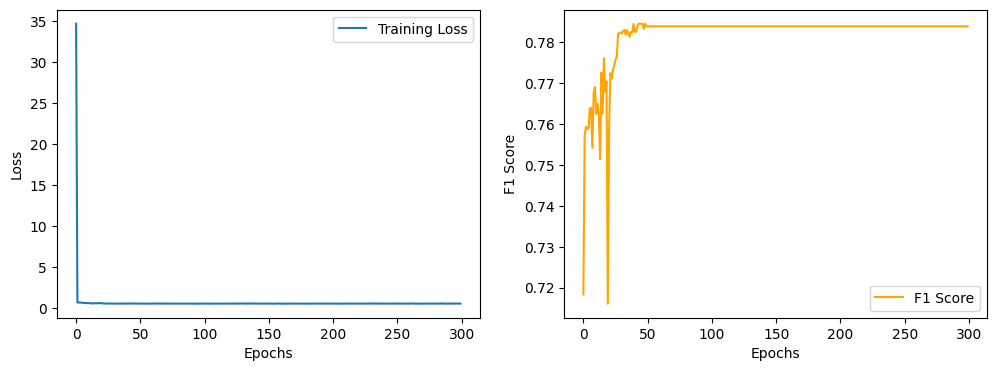

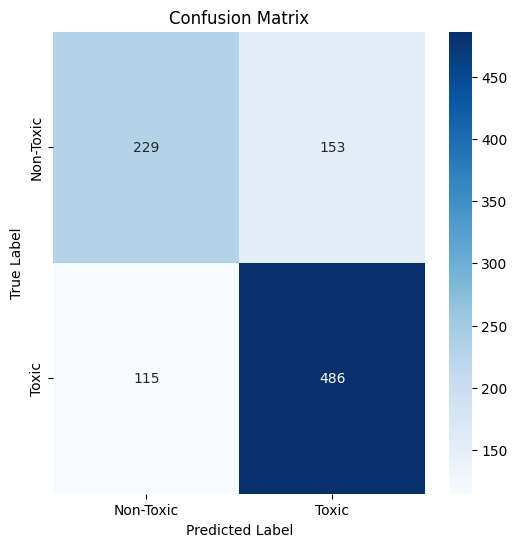

Accuracy: 0.7273652085452695


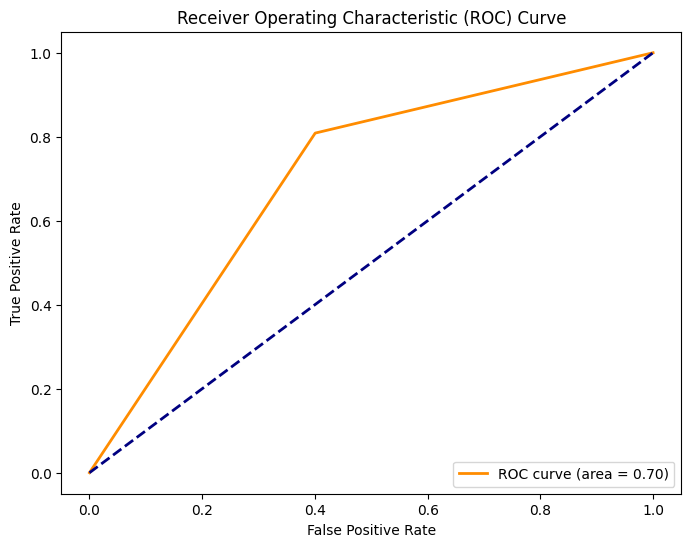

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GraphConv, global_add_pool
from rdkit import Chem
import pandas as pd
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/content/train.csv')  # Replace 'your_data.csv' with the actual file path

# Preprocess the data
smiles_list = data['SMILES'].tolist()
toxicity_labels = (data['Toxicity'] == 'Toxic').astype(int).tolist()

# Create RDKit Mol objects from SMILES
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

def mol_to_graph(mol):
    num_atoms = mol.GetNumAtoms()

    # Extract atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.extend([atom.GetAtomicNum(),
                              atom.GetDegree(),
                              atom.GetFormalCharge(),
                              atom.GetImplicitValence(),
                              atom.GetIsAromatic(),
                              atom.GetMass(),
                              atom.GetNumExplicitHs(),
                              atom.GetNumImplicitHs(),
                              atom.GetNumRadicalElectrons(),
                              atom.GetTotalNumHs(),
                              atom.GetTotalValence(),
                              atom.GetHybridization(),
                              atom.GetExplicitValence(),
                              atom.GetIsotope(),
                              atom.GetChiralTag(),
                              atom.GetNumImplicitHs(),
                              atom.GetNumRadicalElectrons(),
                              atom.GetNumRadicalElectrons(),
                              atom.GetTotalNumHs(),
                              atom.GetTotalValence()])

    x = np.array(atom_features).reshape(-1, len(atom_features) // num_atoms)

    # Extract bond features
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # Assuming an undirected graph
        edge_attr.extend([bond.GetBondTypeAsDouble(),
                          bond.GetIsConjugated(),
                          bond.IsInRing()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 3)  # Adjust based on your bond features

    # Create a Data object
    data = Data(x=torch.tensor(x, dtype=torch.float), edge_index=edge_index, edge_attr=edge_attr)

    return data

# Create a list of graphs, each with its own batch attribute
graphs = [mol_to_graph(mol) for mol in mols]

from torch.utils.data import Dataset

class MolGraphDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph = self.graphs[idx]
        label = self.labels[idx]
        return graph, label

# Create the dataset and dataloader
dataset = MolGraphDataset(graphs, toxicity_labels)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


# Print the first element
first_element = graphs[5]
print(first_element)

# Print edge index
print("Edge Index:")
print(first_element.edge_index)

# Print atom features
print("\nAtom Features:")
print(first_element.x)

print(first_element.edge_attr)



class DynamicGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(DynamicGCN, self).__init__()

        self.graph_convs = nn.ModuleList([
            GraphConv(input_dim, hidden_dim),
            GraphConv(hidden_dim, hidden_dim),
            GraphConv(hidden_dim, hidden_dim)
        ])

        self.dropouts = nn.ModuleList([
            nn.Dropout(dropout_rate),
            nn.Dropout(dropout_rate),
            nn.Dropout(dropout_rate)
        ])

        self.dense = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        if x is not None:
            # Perform dynamic operations based on dimensions
            for conv, dropout in zip(self.graph_convs, self.dropouts):
                x = conv(x, edge_index)
                x = torch.relu(x)
                x = dropout(x)

            x = global_add_pool(x, batch)
            output = self.dense(x)
            return output
        else:
            x = torch.zeros(batch.size(0), 1)
            x = x.to(device)
            output = self.dense(x)
            return output

# Instantiate the model with dropout and an additional layer
model = DynamicGCN(input_dim=20, hidden_dim=128, output_dim=1, dropout_rate=0.5)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # Reduced learning rate

# Add gradient clipping
clip_value = 1  # Adjusted gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

# Add learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)



# Training loop
num_epochs = 300
train_losses = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_data in loader:
        optimizer.zero_grad()

        # Unpack the batch
        input_features, labels = batch_data[0], batch_data[1]

        # Forward pass
        output = model(input_features)

        # Calculate loss
        loss = criterion(output.squeeze(), labels.float())  # Adjust based on your data types

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(loader)
    train_losses.append(avg_epoch_loss)

    # Evaluation on the entire dataset for accuracy and F1 score
    model.eval()
    all_predictions = []
    all_labels = []

    for batch_data in loader:
        # Unpack the batch
        input_features, labels = batch_data[0], batch_data[1]

        # Forward pass
        output = model(input_features)

        predictions = torch.sigmoid(output).round().squeeze().detach().cpu().numpy()
        labels = labels.squeeze().cpu().numpy()

        all_predictions.extend(predictions)
        all_labels.extend(labels)

    # Calculate F1 score
    f1 = f1_score(all_labels, np.round(all_predictions))
    f1_scores.append(f1)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss}, F1 Score: {f1}')

    # Update learning rate using scheduler
    scheduler.step(avg_epoch_loss)





# Plotting the loss curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting F1 score vs epochs
plt.subplot(1, 2, 2)
plt.plot(f1_scores, label='F1 Score', color='orange')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, np.round(all_predictions))
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print accuracy
accuracy = (np.array(all_labels) == np.round(all_predictions)).mean()
print(f'Accuracy: {accuracy}')

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


